## Imports

In [10]:
import numpy as np
import cv2 as cv
import os
import math
import faiss

import matplotlib.pyplot as plt
%matplotlib inline

## SIFT

In [52]:
def get_sift_keypoints(img, resize_width=1366):
    dsize = (resize_width, int(img.shape[0] / (img.shape[1] / resize_width)))
    img = cv.resize(img, dsize)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create(nfeatures=1500)
    kp, des = sift.detectAndCompute(gray, None)
    img=cv.drawKeypoints(img,kp,img)
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return kp, des

In [53]:
def create_sift_database():
    labels = []
    features = []
    for image_name in os.listdir('images'):
        if '.jpeg' not in image_name and '.jpg' not in image_name:
            continue
        index_of_dot = image_name.find('.')
        building_name = image_name[0:(index_of_dot - 2)]

        image_path = 'images/' + image_name
        img = cv.imread(image_path)

        kp, des = get_sift_keypoints(img)
        labels += [building_name for i in range(len(kp))]

        features.append(np.vstack(des))
    return labels, features

## ORB

In [54]:
def get_orb_keypoints(img, resize_width=1024):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    dsize = (resize_width, int(gray.shape[0] / (gray.shape[1] / resize_width)))
    gray = cv.resize(gray, dsize)
    orb = cv.ORB_create(nfeatures=1000)
    kp = orb.detect(gray,None)
    kp, des = orb.compute(gray, kp)
    img=cv.drawKeypoints(gray,kp,img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return kp, des

In [55]:
def create_orb_database():
    labels = []
    features = []
    for image_name in os.listdir('images'):
        if '.jpeg' not in image_name and '.jpg' not in image_name:
            continue
        index_of_dot = image_name.find('.')
        building_name = image_name[0:(index_of_dot - 2)]

        image_path = 'images/' + image_name
        img = cv.imread(image_path)

        kp, des = get_orb_keypoints(img)
        labels += [building_name for i in range(len(kp))]

        features.append(np.vstack(des))
    return labels, features

## BRIEF

In [56]:
def get_brief_keypoints(img, resize_width=1024):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    dsize = (resize_width, int(gray.shape[0] / (gray.shape[1] / resize_width)))
    gray = cv.resize(gray, dsize)
    star = cv.xfeatures2d.StarDetector_create()
    kp = star.detect(gray,None)
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
    kp, des = brief.compute(gray, kp)
    img=cv.drawKeypoints(gray,kp,img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return kp, des

In [57]:
def create_brief_database():
    labels = []
    features = []
    for image_name in os.listdir('images'):
        if '.jpeg' not in image_name and '.jpg' not in image_name:
            continue
        index_of_dot = image_name.find('.')
        building_name = image_name[0:(index_of_dot - 2)]

        image_path = 'images/' + image_name
        img = cv.imread(image_path)

        kp, des = get_brief_keypoints(img)
        labels += [building_name for i in range(len(kp))]

        features.append(np.vstack(des))
    return labels, features

## Feature Set Creation

In [58]:
def create_requested_feature_database(create_database):
    labels, features = create_database()
    features_ar = np.vstack(features)
    faiss_size = list(features_ar.shape)[1]
    index = faiss.IndexFlatL2(faiss_size)
    index.add(features_ar)
    return labels, index

## Inference

In [78]:
def get_percentage_scores(top_tuple_list, softmax_temp=0.001):
    # Softmax calculation
    top_list = []
    sum_of_scores = 0
    for score, name in top_tuple_list:
        top_list.append(name)
        sum_of_scores += math.exp(score / softmax_temp)
    percentage_scores = [math.exp(top_tuple_list[i][0] / softmax_temp) * 100 / sum_of_scores for i in range(len(top_tuple_list))]
    return top_list, percentage_scores

In [79]:
def find_closest_image_match(img, k, method):
    if method == 'sift':
        kp, des = get_sift_keypoints(img)

    elif method == 'orb':
        kp, des = get_orb_keypoints(img)
        
    elif method == 'brief':
        kp, des = get_brief_keypoints(img)

    else:
        return None
    
    preds = {}
    for d in des:
        D, I = index.search(d.reshape((1, index.d)), k)
        for i, idx in enumerate(I[0]):
            pred = labels[idx]
            if pred not in preds:
                preds[pred] = 0
            preds[pred] += 1 / (i + 1)
    print(preds)
    top_tuple_list = sorted([(v, k) for k, v in preds.items()], reverse=True)
    scores = [top_tuple[0] for top_tuple in top_tuple_list]
    top_tuple_list = [(v-max(scores), k) for v, k in top_tuple_list]
    top_list, percentage_scores = get_percentage_scores(top_tuple_list)
    return top_list, percentage_scores

## Example : SIFT

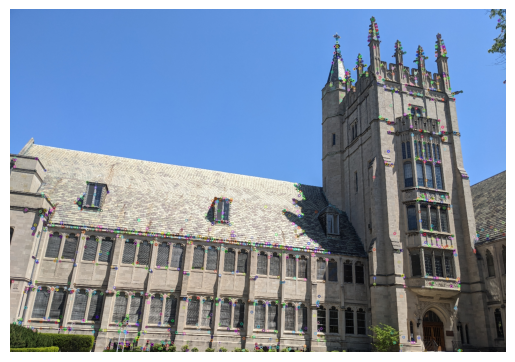

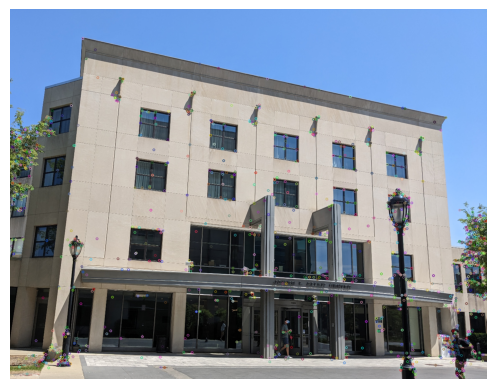

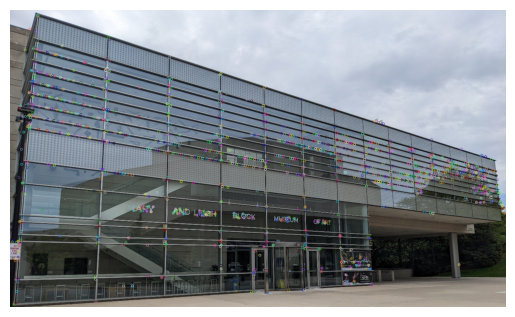

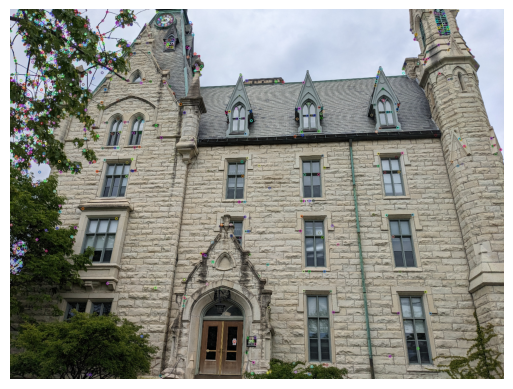

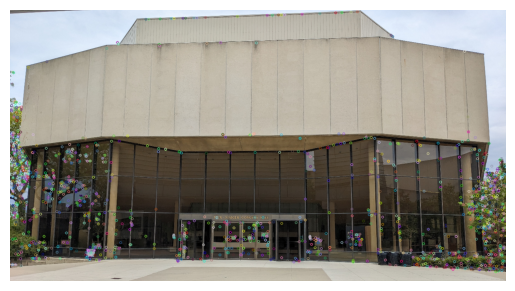

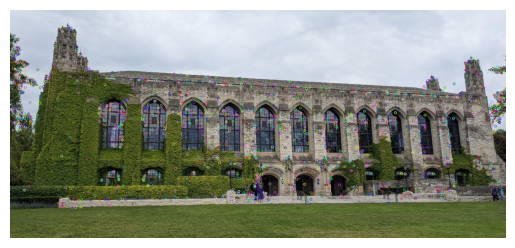

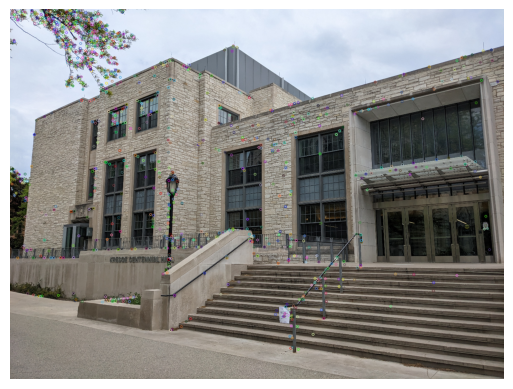

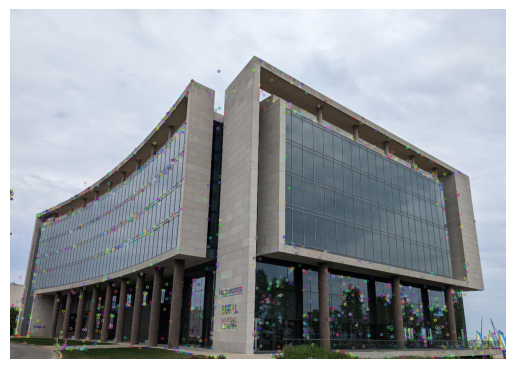

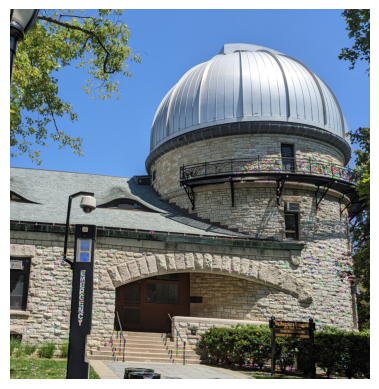

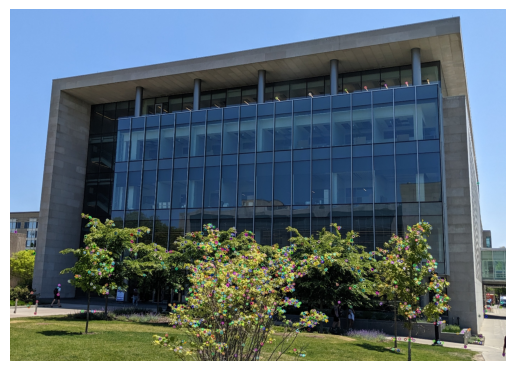

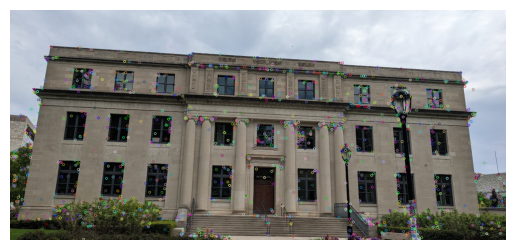

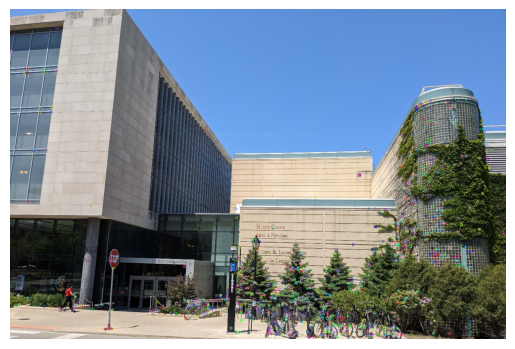

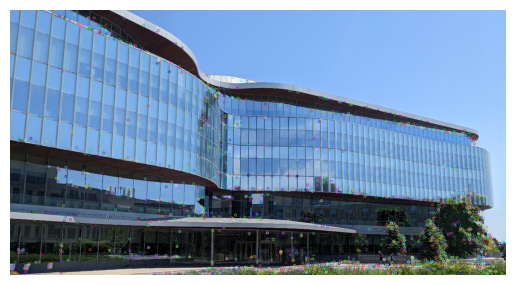

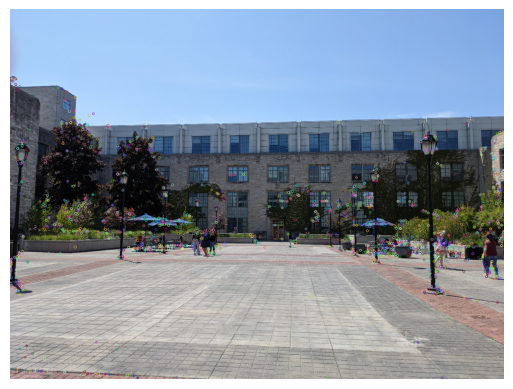

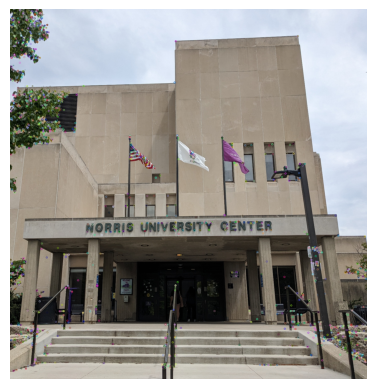

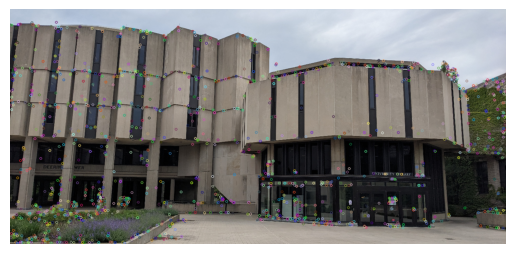

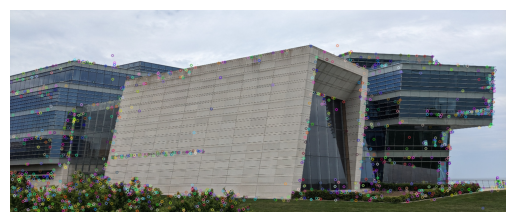

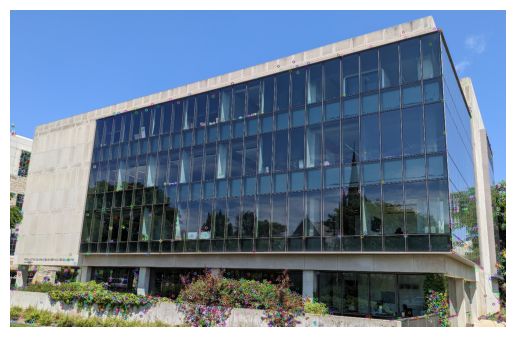

In [71]:
labels, index = create_requested_feature_database(create_sift_database)

jameslallen_test
(3024, 4032, 3)


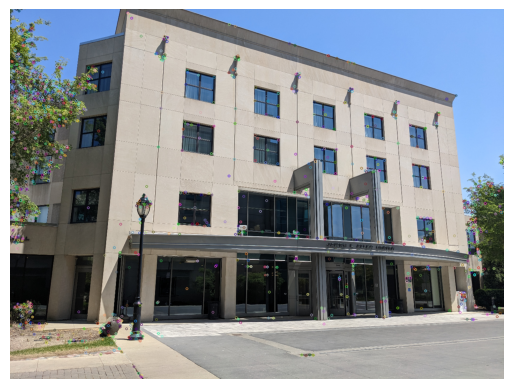

{'James L Allen Cent': 0.047552871125555105, 'Harris Ha': 0.00598843238458471, 'Kellogg Global H': 0.004741613465166431, 'Pick-Staiger Concert Ha': 0.00471480413120809, 'Henry Crown Sports Pavili': 0.0026592513198726558, 'University Ha': 0.0021979884263034263, 'Kresge Centennial Ha': 0.003050829887371416, 'Deering Libra': 0.002368051171243821, 'Norris University Cent': 0.003030173172495772, 'University Libra': 0.003798777508212562, 'Garrett-Evangelical Theological Semina': 0.0025862193593644343, 'Ford Motor Company Engineering Design Cent': 0.0031352267002286455, 'Segal Visitors Cent': 0.0031191895419292273, 'Technological Institute (Bac': 0.002397094779736152, 'Block Museum of A': 0.003279806216167673, 'Mudd Libra': 0.0026104170159002467, 'Bienen School of Mus': 0.004042609045365398, 'Dearborn Observato': 0.002511917222654847}
James L Allen Cent with 100.00% confidence
Harris Ha with 0.00% confidence
Kellogg Global H with 0.00% confidence
Pick-Staiger Concert Ha with 0.00% confidence


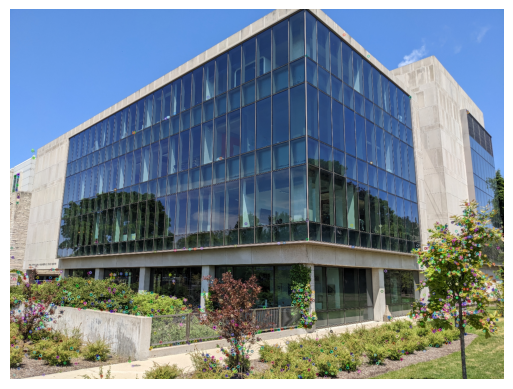

{'University Ha': 0.0028148957093568593, 'Mudd Libra': 0.0038891866059718627, 'Dearborn Observato': 0.0040918866797243015, 'Ford Motor Company Engineering Design Cent': 0.004400024857209281, 'Garrett-Evangelical Theological Semina': 0.002255016976078303, 'Bienen School of Mus': 0.0020556102731416094, 'Henry Crown Sports Pavili': 0.003460269801689971, 'University Libra': 0.0018833304958043356, 'Kresge Centennial Ha': 0.0031488809413843543, 'Harris Ha': 0.0018612358100276024, 'Norris University Cent': 0.002479339951087449, 'Segal Visitors Cent': 0.001198084967464678, 'Pick-Staiger Concert Ha': 0.0028963959068837005, 'James L Allen Cent': 0.0020792408941085272, 'Technological Institute (Bac': 0.002601714838859591, 'Deering Libra': 0.0027491564590447722, 'Block Museum of A': 0.001373832696081343, 'Kellogg Global H': 0.002177439090597579}
Ford Motor Company Engineering Design Cent with 21.69% confidence
Dearborn Observato with 15.94% confidence
Mudd Libra with 13.01% confidence
Henry Crown 

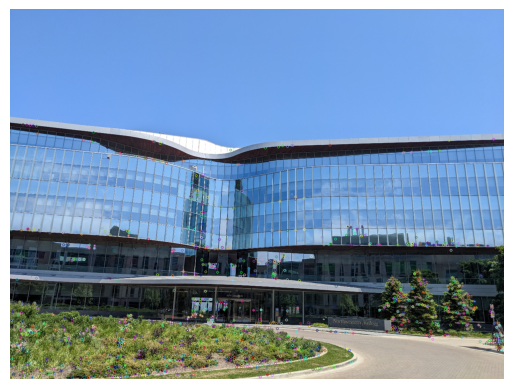

{'Henry Crown Sports Pavili': 0.0038658102875375284, 'Deering Libra': 0.003055694293812929, 'Technological Institute (Bac': 0.0032257977217849156, 'Norris University Cent': 0.002624111647337256, 'Block Museum of A': 0.002702167486604714, 'University Libra': 0.006243666458648609, 'Mudd Libra': 0.0034044951700504308, 'Bienen School of Mus': 0.0029215084159550627, 'Dearborn Observato': 0.0030462561084401312, 'Segal Visitors Cent': 0.00518154481323763, 'Kellogg Global H': 0.017204465620807248, 'Garrett-Evangelical Theological Semina': 0.003355741939747113, 'Harris Ha': 0.004705008481740402, 'Ford Motor Company Engineering Design Cent': 0.003358697065662137, 'Pick-Staiger Concert Ha': 0.0038675186009356536, 'University Ha': 0.0022016068743854443, 'James L Allen Cent': 0.004159213568120308, 'Kresge Centennial Ha': 0.0028479316066726532}
Kellogg Global H with 100.00% confidence
University Libra with 0.00% confidence
Segal Visitors Cent with 0.00% confidence
Harris Ha with 0.00% confidence
Jam

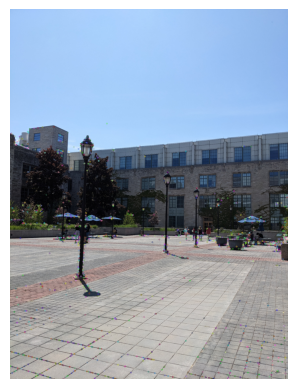

{'Block Museum of A': 0.06509332644148602, 'Deering Libra': 0.0027659624904047718, 'University Ha': 0.005604877449630668, 'Garrett-Evangelical Theological Semina': 0.0028906728513925077, 'Bienen School of Mus': 0.004342649751980696, 'Kellogg Global H': 0.008239229305656464, 'James L Allen Cent': 0.005423416799196514, 'Kresge Centennial Ha': 0.0035752660299249975, 'Technological Institute (Bac': 0.01063945514867606, 'Norris University Cent': 0.0026032488715438417, 'Henry Crown Sports Pavili': 0.0025092752043416387, 'Pick-Staiger Concert Ha': 0.005253750932427758, 'Mudd Libra': 0.001961747985410545, 'Ford Motor Company Engineering Design Cent': 0.002444255766180647, 'Segal Visitors Cent': 0.007664344141140664, 'University Libra': 0.010248815906353142, 'Harris Ha': 0.004863621581912543, 'Dearborn Observato': 0.0030003037990785305}
Block Museum of A with 100.00% confidence
Technological Institute (Bac with 0.00% confidence
University Libra with 0.00% confidence
Kellogg Global H with 0.00% 

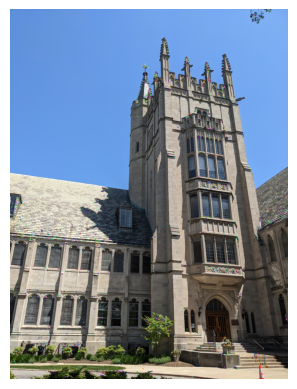

{'Mudd Libra': 0.002713519611974079, 'Ford Motor Company Engineering Design Cent': 0.0023987677774657493, 'Harris Ha': 0.0030176902559098905, 'Garrett-Evangelical Theological Semina': 0.032235385066036945, 'Norris University Cent': 0.003133654381603133, 'University Libra': 0.0029228855388222816, 'Deering Libra': 0.00263658596072948, 'Kellogg Global H': 0.002509869210488117, 'Pick-Staiger Concert Ha': 0.00323010432064762, 'Kresge Centennial Ha': 0.004068085544556598, 'University Ha': 0.0032837209077604132, 'Dearborn Observato': 0.0037333544520805942, 'Technological Institute (Bac': 0.002168910598665066, 'Block Museum of A': 0.006965081015996401, 'Segal Visitors Cent': 0.003723728424758807, 'Henry Crown Sports Pavili': 0.004398472254463115, 'James L Allen Cent': 0.0036931086456414696, 'Bienen School of Mus': 0.0022792445768010858}
Garrett-Evangelical Theological Semina with 100.00% confidence
Block Museum of A with 0.00% confidence
Henry Crown Sports Pavili with 0.00% confidence
Kresge C

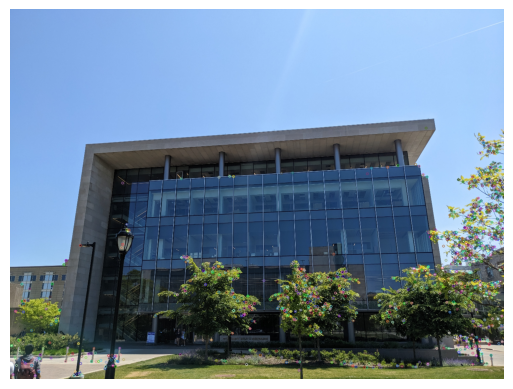

{'Dearborn Observato': 0.0037526029419959537, 'Ford Motor Company Engineering Design Cent': 0.0034964931648597077, 'Henry Crown Sports Pavili': 0.002733278986339039, 'Bienen School of Mus': 0.002075320064870002, 'Technological Institute (Bac': 0.0030844794905481895, 'Kellogg Global H': 0.0016802015493871478, 'Norris University Cent': 0.002273072368277318, 'Garrett-Evangelical Theological Semina': 0.002224462195774549, 'James L Allen Cent': 0.0037600140159289807, 'Segal Visitors Cent': 0.0015167726099818853, 'Kresge Centennial Ha': 0.0025662970321644997, 'University Ha': 0.0033431031121673675, 'Mudd Libra': 0.003954793187517205, 'Pick-Staiger Concert Ha': 0.002157032551920497, 'Deering Libra': 0.002682816255856074, 'University Libra': 0.0021542005068414726, 'Harris Ha': 0.0021993713012900184, 'Block Museum of A': 0.0009705023394352233}
Mudd Libra with 15.83% confidence
James L Allen Cent with 13.03% confidence
Dearborn Observato with 12.93% confidence
Ford Motor Company Engineering Desi

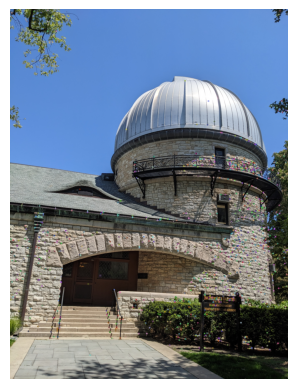

{'Garrett-Evangelical Theological Semina': 0.0034185843172469055, 'Mudd Libra': 0.0033701421635460673, 'Bienen School of Mus': 0.0016610671194342466, 'Technological Institute (Bac': 0.0024352568392317516, 'University Libra': 0.0016830240508065029, 'Dearborn Observato': 0.034133512982668125, 'Kellogg Global H': 0.0017885026461985558, 'Kresge Centennial Ha': 0.003193643906495329, 'Segal Visitors Cent': 0.0013364242850145212, 'Norris University Cent': 0.0019223864561392532, 'Harris Ha': 0.0016761884929626973, 'Deering Libra': 0.002707614413356863, 'University Ha': 0.00313786529187693, 'Block Museum of A': 0.002171987936762609, 'Pick-Staiger Concert Ha': 0.0022875645293646257, 'Henry Crown Sports Pavili': 0.003216927675689026, 'James L Allen Cent': 0.001631042937250121, 'Ford Motor Company Engineering Design Cent': 0.002268990191506968}
Dearborn Observato with 100.00% confidence
Garrett-Evangelical Theological Semina with 0.00% confidence
Mudd Libra with 0.00% confidence
Henry Crown Sports

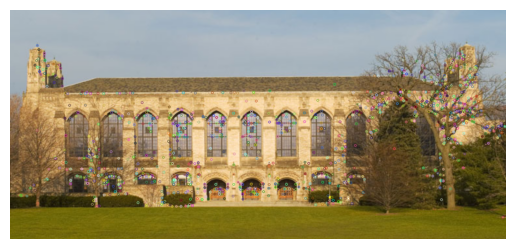

{'Block Museum of A': 0.003237535479173134, 'Mudd Libra': 0.0021720346936091, 'Harris Ha': 0.0021166213753110404, 'Segal Visitors Cent': 0.002279012311643272, 'Dearborn Observato': 0.0032530252253920216, 'Norris University Cent': 0.0019604619178502877, 'Pick-Staiger Concert Ha': 0.002724420344292964, 'University Libra': 0.002331867991497561, 'Bienen School of Mus': 0.002157281214708458, 'University Ha': 0.0023962112866684256, 'Deering Libra': 0.012351718455104039, 'Garrett-Evangelical Theological Semina': 0.0038668766638210363, 'Kellogg Global H': 0.0028055980063745323, 'Technological Institute (Bac': 0.0033499706064509705, 'Henry Crown Sports Pavili': 0.002271408350853083, 'Ford Motor Company Engineering Design Cent': 0.0022019761620669653, 'James L Allen Cent': 0.0022627536205174622, 'Kresge Centennial Ha': 0.0031218000552909763}
Deering Libra with 99.88% confidence
Garrett-Evangelical Theological Semina with 0.02% confidence
Technological Institute (Bac with 0.01% confidence
Dearbor

In [80]:
for image_name in os.listdir('search_images'):
    if '.jpeg' not in image_name and '.jpg' not in image_name:
        continue
    index_of_dot = image_name.find('.')
    building_name = image_name[0:index_of_dot]
    image_path = 'search_images/' + image_name
    img = cv.imread(image_path)
    
    print(building_name)
    print(img.shape)
    k=5
    method = "sift"
    top_list, percentage_scores = find_closest_image_match(img,k,method)
    for i in range(len(top_list)):
        name = top_list[i]
        percentage_score = percentage_scores[i]
        print(f'{name} with {percentage_score:.2f}% confidence')
    print()

## Example : ORB

In [ ]:
labels, index = create_requested_feature_database(create_orb_database)

In [ ]:
for image_name in os.listdir('search_images'):
    if '.jpeg' not in image_name and '.jpg' not in image_name:
        continue
    index_of_dot = image_name.find('.')
    building_name = image_name[0:index_of_dot]
    image_path = 'search_images/' + image_name
    img = cv.imread(image_path)
    
    print(building_name)
    print(img.shape)
    k=5
    method = "orb"
    top_list, percentage_scores = find_closest_image_match(img,k,method)
    for i in range(len(top_list)):
        name = top_list[i]
        percentage_score = percentage_scores[i]
        print(f'{name} with {percentage_score:.2f}% confidence')
    print()

## Example : BRIEF

In [ ]:
# labels, index = create_requested_feature_database(create_brief_database)

In [ ]:
# for image_name in os.listdir('search_images'):
#     if '.jpeg' not in image_name and '.jpg' not in image_name:
#         continue
#     index_of_dot = image_name.find('.')
#     building_name = image_name[0:index_of_dot]
#     image_path = 'search_images/' + image_name
#     img = cv.imread(image_path)
    
#     print(building_name)
#     print(img.shape)
#     k=5
#     method = "brief"
#     top_list, percentage_scores = find_closest_image_match(img,k,method)
#     for i in range(len(top_list)):
#         name = top_list[i]
#         percentage_score = percentage_scores[i]
#         print(f'{name} with {percentage_score:.2f}% confidence')
#     print()